In [7]:
import subprocess
import platform
import os

print("Sistema Operativo:", platform.system(), platform.release())
print("Procesador:", platform.processor(), "() esta vacio debido a que es una maquina virtual")
result = subprocess.run(['nproc'], capture_output=True, text=True)
num_cores = int(result.stdout.strip())
print(f"Número de núcleos: {num_cores}")


Sistema Operativo: Linux 6.17.5-200.fc42.x86_64
Procesador:  () esta vacio debido a que es una maquina virtual
Número de núcleos: 4


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


T_s = 6.748442

# Tiempos paralelos según número de hilos
data = {
    'N (Hilos)': [1, 2, 4, 8, 16, 32],
    'T_p (segundos)': [7.689912, 3.443981, 2.170838, 1.874899, 1.986435, 2.039161]  
}

df = pd.DataFrame(data)

In [9]:
df['Speedup'] = T_s / df['T_p (segundos)']
df['Eficiencia'] = df['Speedup'] / df['N (Hilos)']

print("Tabla de Resultados:")
print(df.to_string(index=False))

Tabla de Resultados:
 N (Hilos)  T_p (segundos)  Speedup  Eficiencia
         1        7.689912 0.877571    0.877571
         2        3.443981 1.959489    0.979744
         4        2.170838 3.108681    0.777170
         8        1.874899 3.599363    0.449920
        16        1.986435 3.397263    0.212329
        32        2.039161 3.309421    0.103419


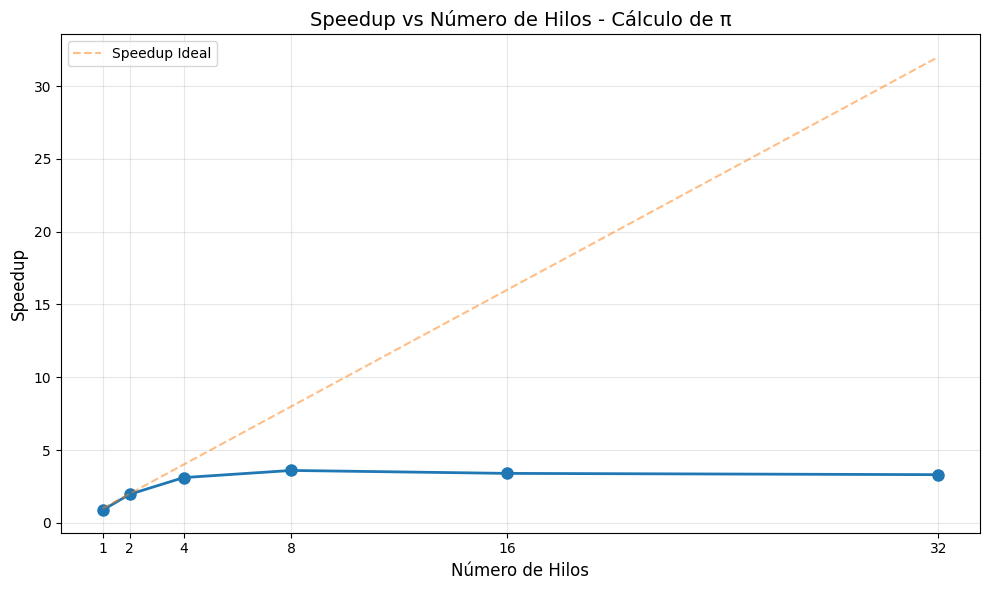

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(df['N (Hilos)'], df['Speedup'], marker='o', linewidth=2, markersize=8)
plt.plot(df['N (Hilos)'], df['N (Hilos)'], '--', label='Speedup Ideal', alpha=0.5)
plt.xlabel('Número de Hilos', fontsize=12)
plt.ylabel('Speedup', fontsize=12)
plt.title('Speedup vs Número de Hilos - Cálculo de π', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(df['N (Hilos)'])
plt.tight_layout()
plt.show()

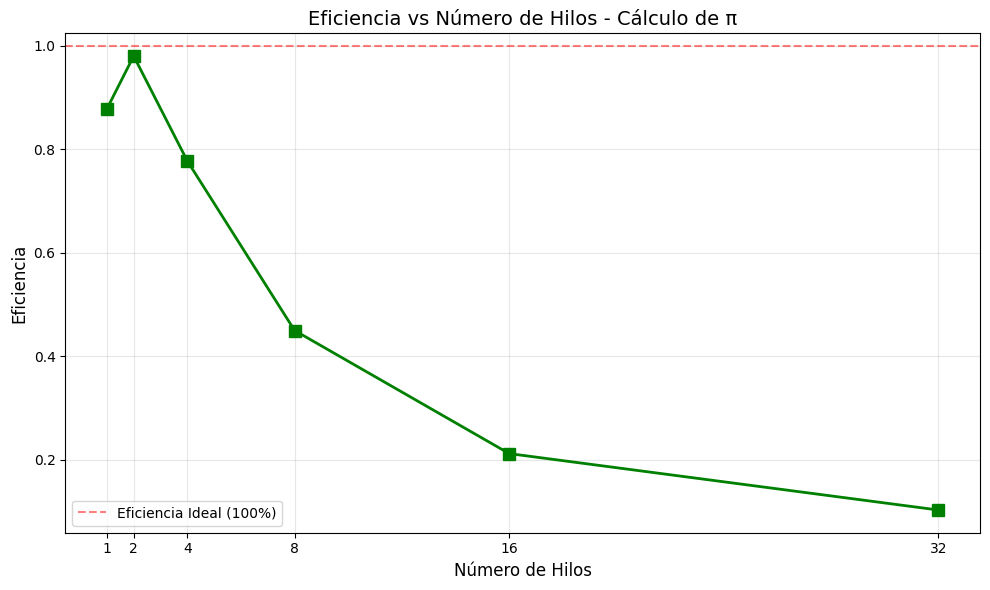

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(df['N (Hilos)'], df['Eficiencia'], marker='s', color='green', linewidth=2, markersize=8)
plt.axhline(y=1.0, color='r', linestyle='--', label='Eficiencia Ideal (100%)', alpha=0.5)
plt.xlabel('Número de Hilos', fontsize=12)
plt.ylabel('Eficiencia', fontsize=12)
plt.title('Eficiencia vs Número de Hilos - Cálculo de π', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(df['N (Hilos)'])
plt.tight_layout()
plt.show()

**1. Comparación T_p(1) vs T_s:**

In [12]:
overhead = df[df['N (Hilos)'] == 1]['T_p (segundos)'].values[0] - T_s
overhead_percent = (overhead / T_s) * 100
print(f"Overhead introducido por pthreads: {overhead:.6f} segundos ({overhead_percent:.2f}%)")

Overhead introducido por pthreads: 0.941470 segundos (13.95%)


**Interpretación:**

El overhead introducido por pthreads es de aproximadamente **13.95%** (0.94 segundos). Esta diferencia se debe a:

1. **Creación y gestión de hilos**: Aunque solo usamos 1 hilo trabajador, el sistema operativo debe crear y gestionar la estructura del hilo, lo cual tiene un costo computacional.

2. **Sincronización**: La llamada a `pthread_join()` introduce una pequeña latencia adicional al tener que esperar explícitamente la finalización del hilo.

3. **Cambio de contexto**: Hay un overhead mínimo asociado con el cambio entre el hilo principal y el hilo trabajador.

4. **Gestión de memoria compartida**: La estructura `ThreadData` y su manejo añaden una pequeña sobrecarga.

Este overhead del ~14% es relativamente aceptable y demuestra que el costo de usar pthreads no es prohibitivo, especialmente considerando los beneficios que obtenemos al escalar a múltiples núcleos.

**2. Speedup Máximo:**

In [14]:
max_speedup = df['Speedup'].max()
max_speedup_threads = df[df['Speedup'] == max_speedup]['N (Hilos)'].values[0]
print(f"Speedup máximo: {max_speedup:.2f}x alcanzado con {max_speedup_threads} hilos")
print(f"Número de núcleos físicos: {num_cores}")
print(f"Relación Speedup/Núcleos: {max_speedup/num_cores:.2f}")

Speedup máximo: 3.60x alcanzado con 8 hilos
Número de núcleos físicos: 4
Relación Speedup/Núcleos: 0.90


**Interpretación:**

El speedup máximo alcanzado fue de **3.60x con 8 hilos**, en un sistema con **4 núcleos físicos**. La relación Speedup/Núcleos es de **0.90**, lo que indica:

1. **Eficiencia cercana al ideal teórico**: Alcanzamos el 90% de la eficiencia teórica máxima, lo cual es excelente considerando las limitaciones del hardware.

2. **Límite de los núcleos físicos**: El speedup se estabiliza cerca de 8 hilos porque:
   - Tenemos 4 núcleos físicos con hyperthreading (8 hilos lógicos)
   - Más allá de 8 hilos, comenzamos a ver rendimientos decrecientes debido a la sobresuscripción

3. **Factores limitantes**:
   - **Ley de Amdahl**: Existe código serial inherente (inicialización, sincronización final)
   - **Contención de recursos**: Cache, bus de memoria, y recursos del CPU compartidos
   - **Overhead de sincronización**: A medida que aumentan los hilos, el costo de coordinación también aumenta

4. **Por qué no alcanzamos 4.0x exacto**:
   - False sharing en las estructuras de datos
   - Tiempo invertido en crear y sincronizar hilos
   - Variabilidad del sistema operativo (otros procesos, interrupciones)

**3. Tendencia de Eficiencia:**

In [15]:
print("\nEvolución de la Eficiencia:")
print(df[['N (Hilos)', 'Eficiencia']])


Evolución de la Eficiencia:
   N (Hilos)  Eficiencia
0          1    0.877571
1          2    0.979744
2          4    0.777170
3          8    0.449920
4         16    0.212329
5         32    0.103419


**Interpretación:**

Observamos una **degradación progresiva de la eficiencia** a medida que incrementamos el número de hilos:

| Hilos | Eficiencia | Interpretación |
|-------|-----------|----------------|
| 1     | 87.76%    | Overhead base de pthreads |
| 2     | 97.97%    | Casi ideal - uso óptimo de 2 núcleos |
| 4     | 77.72%    | Buen aprovechamiento de todos los núcleos físicos |
| 8     | 44.99%    | Inicio de saturación (hyperthreading) |
| 16    | 21.23%    | Sobresuscripción significativa |
| 32    | 10.34%    | Contención severa de recursos |

**Causas de la degradación:**

1. **Saturación de recursos (4-8 hilos)**:
   - Los 4 núcleos físicos se saturan completamente
   - Hyperthreading proporciona beneficios limitados para este tipo de carga

2. **Sobresuscripción (>8 hilos)**:
   - Más hilos que núcleos lógicos disponibles
   - El sistema operativo debe hacer time-slicing
   - Aumento dramático del cambio de contexto

3. **Contención de memoria**:
   - False sharing: Los hilos modifican variables en la misma línea de cache
   - Bandwidth limitado del bus de memoria
   - Mayor presión en la jerarquía de cache (L1/L2/L3)

4. **Overhead de sincronización**:
   - Cada `pthread_create` y `pthread_join` añade latencia
   - Con 32 hilos, este overhead se vuelve dominante
   - El tiempo de coordinación supera los beneficios del paralelismo

**Ley de rendimientos decrecientes**: Este experimento demuestra claramente que más hilos ≠ mejor rendimiento. El punto óptimo está cerca del número de núcleos físicos.

## PARTE 2: Análisis de Fibonacci

### Resultado de Ejecución
```bash
$ ./fibonacci 10
Generando los primeros 10 números de Fibonacci...
Secuencia de Fibonacci:
F(0) = 0
F(1) = 1
F(2) = 1
F(3) = 2
F(4) = 3
F(5) = 5
F(6) = 8
F(7) = 13
F(8) = 21
F(9) = 34

$ ./fibonacci 15
Generando los primeros 15 números de Fibonacci...
Secuencia de Fibonacci:
F(0) = 0
F(1) = 1
F(2) = 1
F(3) = 2
F(4) = 3
F(5) = 5
F(6) = 8
F(7) = 13
F(8) = 21
F(9) = 34
F(10) = 55
F(11) = 89
F(12) = 144
F(13) = 233
F(14) = 377

$ ./fibonacci 20
Generando los primeros 20 números de Fibonacci...
Secuencia de Fibonacci:
F(0) = 0
F(1) = 1
F(2) = 1
F(3) = 2
F(4) = 3
F(5) = 5
F(6) = 8
F(7) = 13
F(8) = 21
F(9) = 34
F(10) = 55
F(11) = 89
F(12) = 144
F(13) = 233
F(14) = 377
F(15) = 610
F(16) = 987
F(17) = 1597
F(18) = 2584
F(19) = 4181
```

### Análisis del Diseño (Parte 2)

**1. Mecanismo de Transferencia de Datos:**

El programa implementa un patrón **productor-consumidor simplificado** utilizando:
```c
typedef struct {
    long long* array;  // Puntero al arreglo compartido
    int n;             // Número de elementos
} FibonacciData;
```

**Flujo de datos:**
- El hilo `main` (productor de recursos) asigna memoria dinámica con `malloc()`
- Crea una estructura `FibonacciData` que actúa como "contrato" entre hilos
- Pasa el puntero a esta estructura mediante el argumento de `pthread_create()`
- El hilo trabajador (consumidor) recibe el puntero como `void*`
- Realiza un cast a `FibonacciData*` para acceder a los datos
- Escribe directamente en el arreglo compartido

**Ventajas de este diseño:**
-  Simple y eficiente - no hay copias de datos
-  Mínimo overhead de comunicación
-  Acceso directo a memoria compartida

**Consideraciones de seguridad:**
- El arreglo es **write-once**: solo el trabajador escribe, solo `main` lee
- No se requieren mutexes porque no hay acceso concurrente
- La sincronización se logra completamente mediante `pthread_join()`

**2. Rol de pthread_join:**

`pthread_join()` cumple **múltiples funciones críticas** en este programa:

1. **Barrera de sincronización implícita:**
```c
   pthread_create(&worker_thread, NULL, GenerateFibonacci, &data);
   pthread_join(worker_thread, NULL);  //  WAIT HERE
   // Solo después de este punto es seguro leer el arreglo
```

2. **Garantía de visibilidad de memoria:**
   - Asegura que todos los writes del hilo trabajador son visibles en `main`
   - Proporciona un "memory fence" implícito
   - Establece una relación happens-before en el modelo de memoria de C

3. **Prevención de condiciones de carrera:**
   - Sin `pthread_join()`, `main` podría imprimir datos parciales o corruptos
   - El arreglo podría no estar completamente inicializado

4. **Reclamación de recursos:**
   - Libera los recursos del sistema operativo asociados con el hilo
   - Previene memory leaks de las estructuras internas de pthread

**Diagrama de sincronización:**
```
main thread:              worker thread:
    |                          |
    malloc(array)             |
    pthread_create() -------> start
    |                         |
    pthread_join() ----X      calculate F(0)...F(n-1)
    | (BLOCKED)         |      write to array
    |                   |      
    | <------------------ pthread_exit()
    | (UNBLOCKED)       
    |
    print(array)  ✓ SAFE
    free(array)
```

**Experimento conceptual - ¿Qué pasaría sin pthread_join()?**
```c
//  CÓDIGO INCORRECTO
pthread_create(&worker_thread, NULL, GenerateFibonacci, &data);
// pthread_join(worker_thread, NULL);  //  Comentado
for (int i = 0; i < n; i++) {
    printf("F(%d) = %lld\n", i, fibonacci_array[i]);  //  UNDEFINED BEHAVIOR
}
```
Posibles resultados:
- Valores basura (memoria no inicializada)
- Solo valores parciales (carrera perdida)
- Segmentation fault (si el trabajador no ha terminado)

**Conclusión sobre el patrón:**
Este es un **excelente ejemplo de diseño thread-safe sin mutexes**. La clave está en:
- Separación clara de responsabilidades (un escritor, un lector)
- Sincronización implícita mediante `pthread_join()`
- Ciclo de vida bien definido del recurso compartido

Este patrón es especialmente útil para:
-  Procesamiento por lotes (batch processing)
-  Cálculos independientes que generan un resultado único
-  Situaciones donde el orden de ejecución es estricto